In [4]:
import kaggle
import zipfile
import os

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
api = KaggleApi()
api.authenticate()
for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./data/')
    with zipfile.ZipFile(f'./data/{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./data/')
    os.remove(f'./data/{file}.zip')

100%|██████████| 1.28M/1.28M [00:09<00:00, 148kB/s]


100%|██████████| 494k/494k [00:04<00:00, 117kB/s]

In [7]:
import pandas as pd
import matplotlib as plt
df = pd.read_csv('./data/train.tsv', sep='\t')
df.head()

/tmp/ipykernel_21352/140341370.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
df.drop_duplicates(subset=['SentenceId'], keep='first')

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<Axes: xlabel='Sentiment'>

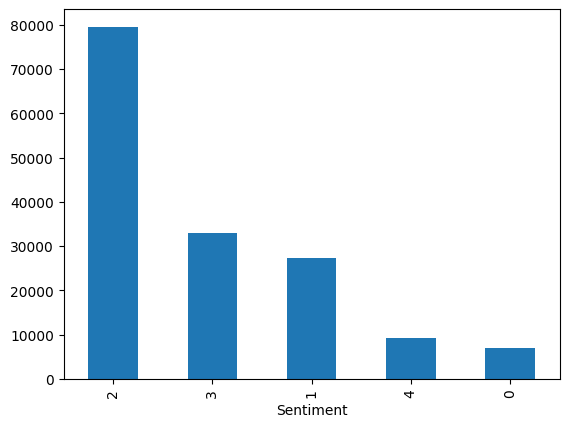

In [9]:
df['Sentiment'].value_counts().plot(kind='bar')

In [10]:
seq_len = 512
num_sample = len(df)

num_sample,seq_len

(156060, 512)

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/home/ashvin/Desktop/Local Repos/Sentiment-Analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 104kB/s]
vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 1.60MB/s]
tokenizer.json: 100%|██████████| 436k/436k [00:00<00:00, 1.67MB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 1.79MB/s]


In [12]:
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length=seq_len, 
                   truncation=True, 
                   padding='max_length',
                   add_special_tokens=True, 
                   return_tensors='np')


In [13]:
tokens.keys()
# tokens['input_ids']

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
import numpy as np 

with open('./np_output/movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('./np_output/movie-xmasks.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [15]:
arr = df['Sentiment'].values
arr.shape
arr

array([1, 2, 2, ..., 3, 2, 2])

In [16]:
arr.max()+1

5

In [17]:
label = np.zeros((num_sample, arr.max()+1))
label.shape
label

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [18]:
label[np.arange(num_sample), arr] = 1
label

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [19]:
with open('./np_output/movie-labels.npy', 'wb') as f:
    np.save(f, label)